# Model training


In [2]:
from matplotlib import pyplot as plt 
import seaborn as sns
import pandas as pd
import numpy as np
import pickle
import os

In [3]:
DATA_SUBDIR = '../data'

##### Importing the data

Here I'll be using the data exported in `data_analysis.ypynb`


In [4]:
data = pd.read_pickle(os.path.join(DATA_SUBDIR, 'train.pkl'))
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 371848 entries, 388024 to 451283
Data columns (total 20 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   altura                  371848 non-null  int64  
 1   exposicion              371848 non-null  int64  
 2   inclinacion_suelo       371848 non-null  int64  
 3   distancia_agua          371848 non-null  int64  
 4   altura_agua             371848 non-null  int64  
 5   distancia_caminos       371848 non-null  int64  
 6   sombra_maniana          371848 non-null  int64  
 7   sombra_mediodia         371848 non-null  int64  
 8   sombra_tarde            371848 non-null  int64  
 9   distancia_fuego         371848 non-null  int64  
 10  clase_suelo             371848 non-null  int64  
 11  dosel_forestal          371848 non-null  int64  
 12  sombra                  371848 non-null  float64
 13  clase_area_silvestre_1  371848 non-null  uint8  
 14  clase_area_silv

In [5]:
data.head()

,altura,exposicion,inclinacion_suelo,distancia_agua,altura_agua,distancia_caminos,sombra_maniana,sombra_mediodia,sombra_tarde,distancia_fuego,clase_suelo,dosel_forestal,sombra,clase_area_silvestre_1,clase_area_silvestre_2,clase_area_silvestre_3,clase_area_silvestre_4,clase_suelo_10,clase_suelo_39,clase_suelo_38
388024,3372,91,13,603,215,1401,240,219,108,1022,39,7,189.000000,0,0,1,0,0,1,0
254008,2521,42,7,124,13,882,221,225,139,934,6,2,195.000000,0,0,0,1,0,0,0
349506,3197,92,8,85,6,390,233,228,128,1920,22,1,196.333333,1,0,0,0,0,0,0
19002,2803,34,12,90,11,4142,218,213,129,5407,29,1,186.666667,1,0,0,0,0,0,0
456137,2596,247,22,242,133,1500,169,250,214,1342,3,3,211.000000,0,0,1,0,0,0,0


Let's separate the prediction data from the target


In [6]:
# Separete the target
target = data['dosel_forestal']
prep_data = data.drop(['dosel_forestal'], axis=1).to_numpy()


## Random Forest

##### Training

Now let us try training a random forest model with the prepared data


In [8]:
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(n_estimators=10, random_state=1234, n_jobs=-1)
rf_classifier.fit(prep_data, target)
rf_prediction = rf_classifier.predict(prep_data)

Let's compare the prediction with the original data in graphs


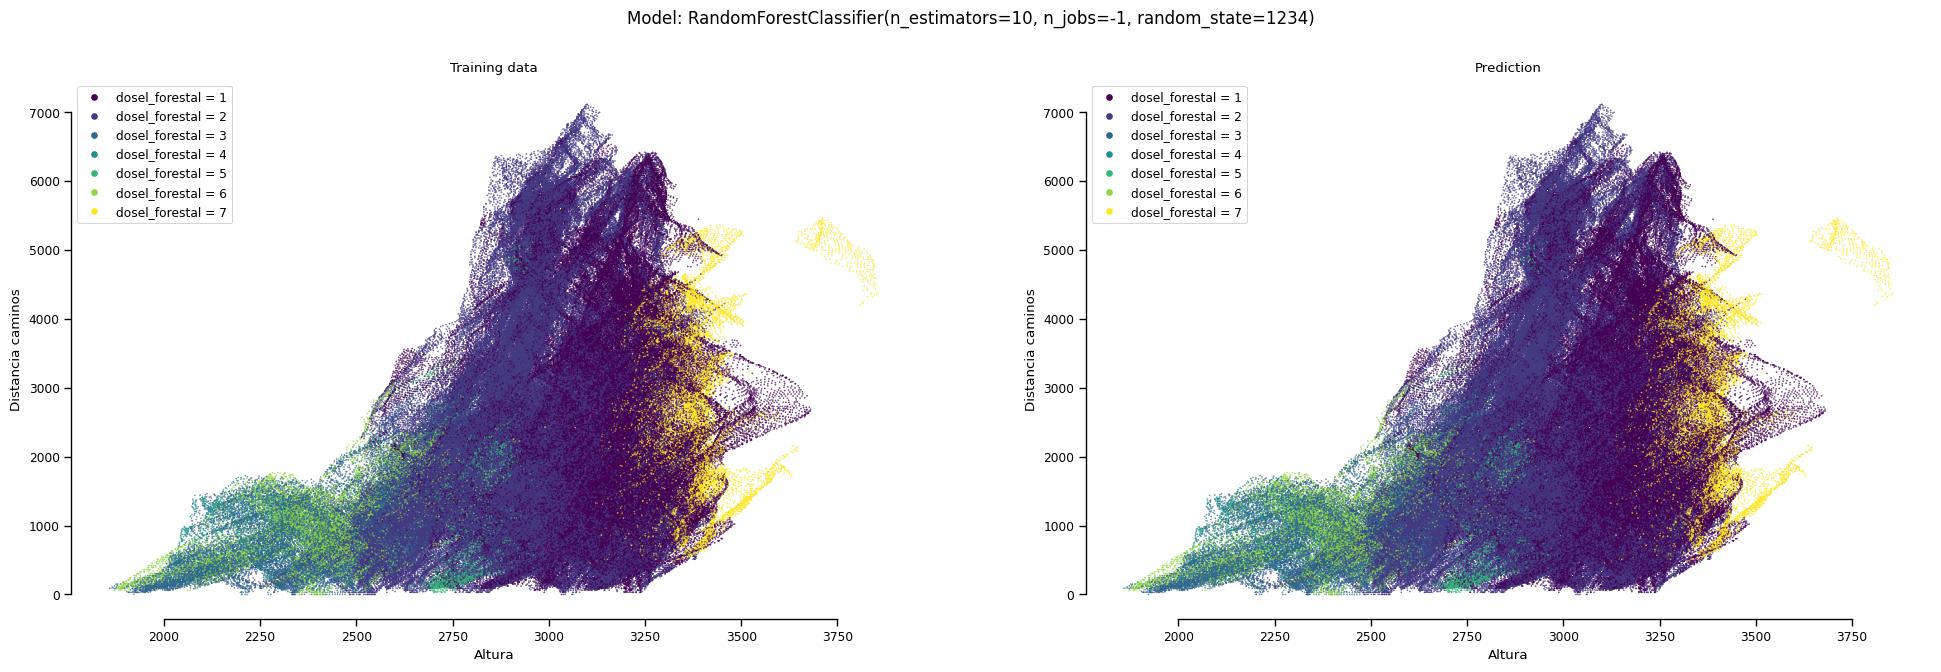

In [9]:
idx_altura = 0; idx_inclinacion_suelo = 2; idx_distancia_caminos = 5; idx_sombra = 11; idx_clase_area_silvestre_4 = 15;


fig = plt.figure(figsize=(24, 7))
fig.suptitle(f'Model: {rf_classifier}')
sns.set_context("paper")

# mask = np.logical_not(prep_data.T[idx_clase_area_silvestre_4].astype('bool'))
ax = fig.add_subplot(121, title="Training data")
sc = ax.scatter(prep_data.T[idx_altura], prep_data.T[idx_distancia_caminos], c=target, s=0.1)

# Legend handles
lp = lambda i: plt.plot([],color=sc.cmap(sc.norm(i)), mec='none', label=f'dosel_forestal = {i:g}', ls='', marker='o')[0]
handles = [lp(i) for i in np.unique(target)]
plt.legend(handles=handles)

ax.set_xlabel("Altura")
ax.set_ylabel("Distancia caminos")

ax = fig.add_subplot(122, title="Prediction")
sc = ax.scatter(prep_data.T[idx_altura], prep_data.T[idx_distancia_caminos], c=rf_prediction, s=0.1)

# Legend handles
handles = [lp(i) for i in np.unique(rf_prediction)]
plt.legend(handles=handles)

ax.set_xlabel("Altura")
ax.set_ylabel("Distancia caminos")

sns.despine(trim=True)

The model seems to do a great job predicting the training data, maybe it is overfitting. Let's check some metrics:


In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

acc = accuracy_score(target.to_numpy(), rf_prediction)
prec = precision_score(target.to_numpy(), rf_prediction, average='macro')
rec = recall_score(target.to_numpy(), rf_prediction, average='macro')

print(f'Accuracy:\t{acc:.8f}\nPrecision:\t{prec:.8f}\nRecall:\t\t{rec:.8f}')

Accuracy:	0.99785127
Precision:	0.99819930
Recall:		0.99381217


These metrics are pretty good but testing against the training set is not a very bold or useful endeavour. Let's do some cross validation.


##### Cross Validation


In [12]:
from sklearn.model_selection import cross_val_score

rf_cv_scores = cross_val_score(rf_classifier, prep_data, target, cv=10, n_jobs=-1)
print(f'Cross Validation score (Accuracy): {rf_cv_scores.mean()} +/- {rf_cv_scores.std()}')

Cross Validation score (Accuracy): 0.937910111965756 +/- 0.0011447139456076333


Of course, this value is lower than the previously calculated accuracy. Our model might probably benefit from some fine tuning, but first let's see how the model does with the testing partition.


##### Testing


In [13]:
from prep_data import preapare_data

# Import testing set
test_set = pd.read_pickle(os.path.join(DATA_SUBDIR, 'test.pkl'))

# Prepare the testing set
prep_test, test_target = preapare_data(test_set)

In [14]:
# Predict 
rf_test_prediction = rf_classifier.predict(prep_test)

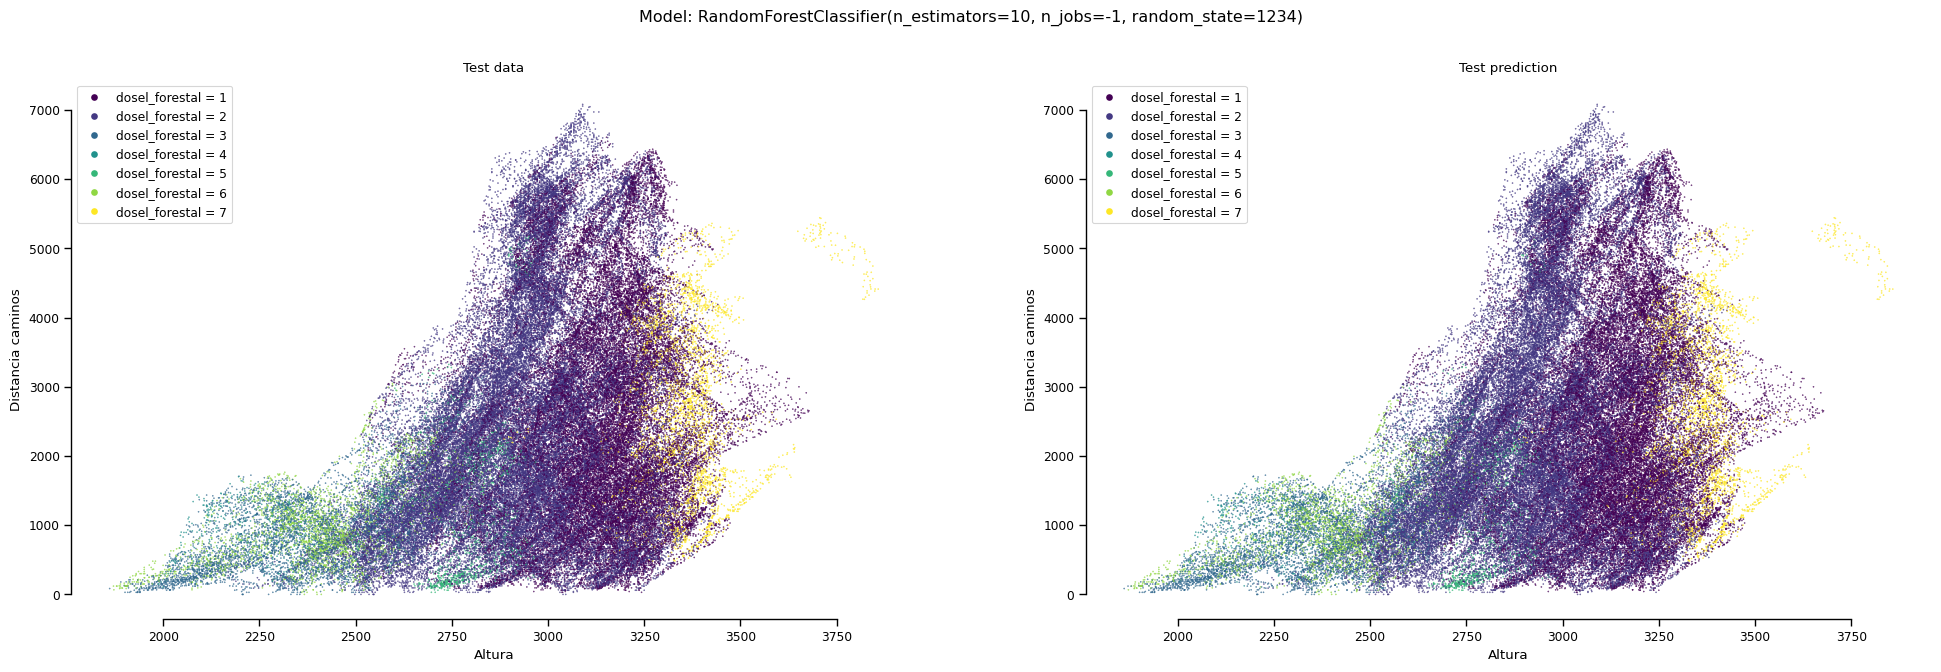

In [15]:
from matplotlib import pyplot as plt

idx_altura = 0; idx_inclinacion_suelo = 2; idx_distancia_caminos = 5; idx_sombra = 11; idx_clase_area_silvestre_4 = 15;


fig = plt.figure(figsize=(24, 7))
fig.suptitle(f'Model: {rf_classifier}')
sns.set_context("paper")

ax = fig.add_subplot(121, title="Test data")
ax.scatter(prep_test.T[idx_altura], prep_test.T[idx_distancia_caminos], c=test_target, s=0.1)

# Legend handles
lp = lambda i: plt.plot([],color=sc.cmap(sc.norm(i)), mec='none', label=f'dosel_forestal = {i:g}', ls='', marker='o')[0]
handles = [lp(i) for i in np.unique(test_target)]
plt.legend(handles=handles)

ax.set_xlabel("Altura")
ax.set_ylabel("Distancia caminos")

ax = fig.add_subplot(122, title="Test prediction")
sc = ax.scatter(prep_test.T[idx_altura], prep_test.T[idx_distancia_caminos], c=rf_test_prediction, s=0.1)

# Legend handles
handles = [lp(i) for i in np.unique(rf_test_prediction)]
plt.legend(handles=handles)

ax.set_xlabel("Altura")
ax.set_ylabel("Distancia caminos")

sns.despine(trim=True)

In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

tacc = accuracy_score(test_target.to_numpy(), rf_test_prediction)
tprec = precision_score(test_target.to_numpy(), rf_test_prediction, average='macro')
trec = recall_score(test_target.to_numpy(), rf_test_prediction, average='macro')

print(f'Accuracy:\t{tacc:.8f}\nPrecision:\t{tprec:.8f}\nRecall:\t\t{trec:.8f}')

Accuracy:	0.94115875
Precision:	0.93431111
Recall:		0.87920856


These metrics are lower than the ones gotten before (of course), but they are still good.


##### Feature importance


In [17]:
importances = rf_classifier.feature_importances_
features = data.drop(['dosel_forestal'], axis=1).columns

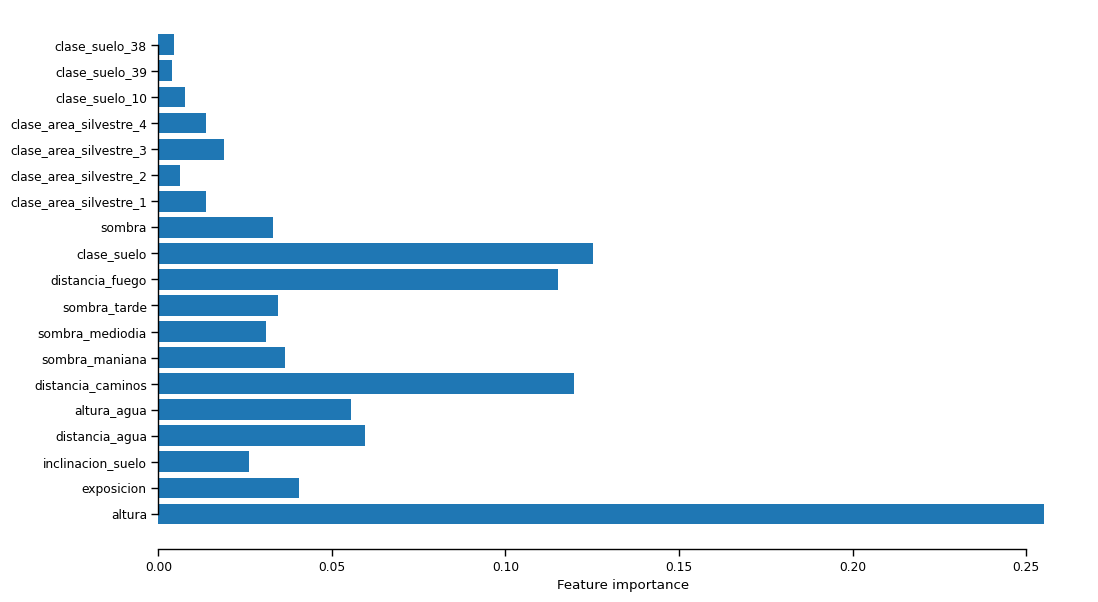

In [18]:
fig, ax = plt.subplots(figsize=(12, 7))
sns.set_context('paper')

ax.barh(features, importances)
ax.set_xlabel('Feature importance')
sns.despine(trim=True)

This feature importances are biased, a better thing to look at is the permutation importance


In [19]:
from sklearn.inspection import permutation_importance

r = permutation_importance(rf_classifier, prep_test, test_target, n_repeats=30, random_state=1234)

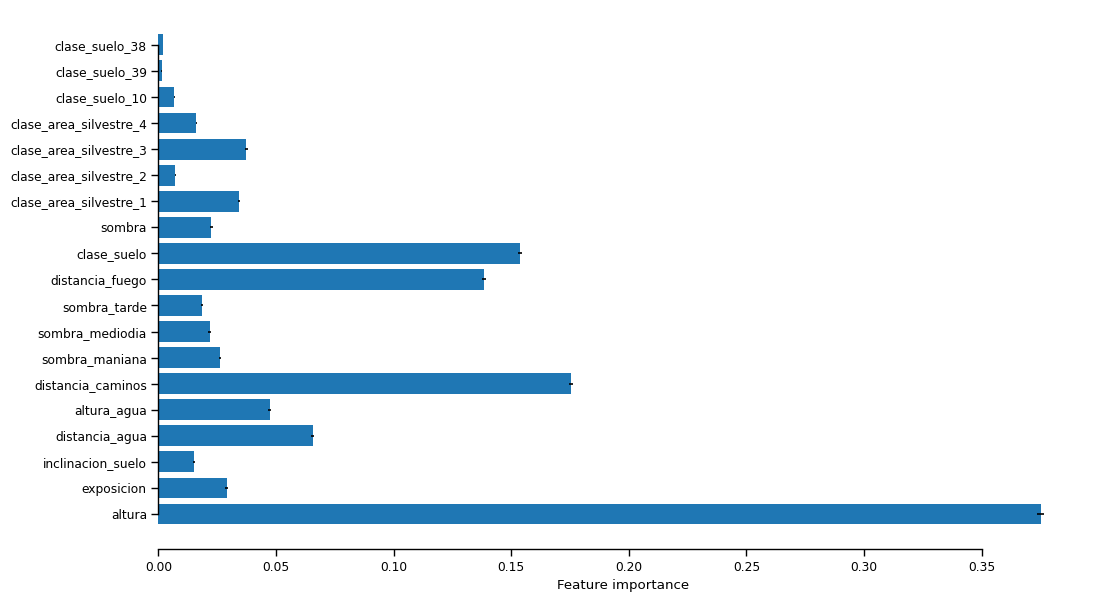

In [20]:
fig, ax = plt.subplots(figsize=(12, 7))
sns.set_context('paper')

ax.barh(features, r.importances_mean, xerr=r.importances_std)
ax.set_xlabel('Feature importance')
sns.despine(trim=True)

Contrary to what I expected the feature `clase_area_silvestre_4` is not very important to the model and others with lower correlation have a highest importance.


## XGBoost


##### Training


In [52]:
from xgboost import XGBClassifier

xgb_classifier = XGBClassifier(n_estimators=50, random_state=1234, n_jobs=-1)
xgb_classifier.fit(prep_data, target - 1)
xgb_prediction = xgb_classifier.predict(prep_data) + 1

In [53]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

xgbacc = accuracy_score(target.to_numpy(), xgb_prediction)
xgbprec = precision_score(target.to_numpy(), xgb_prediction, average='macro')
xgbrec = recall_score(target.to_numpy(), xgb_prediction, average='macro')

print(f'Accuracy:\t{xgbacc:.8f}\nPrecision:\t{xgbprec:.8f}\nRecall:\t\t{xgbrec:.8f}')

Accuracy:	0.83554571
Precision:	0.86456546
Recall:		0.77368356


The result is much worse than the result using the Random Forest even for the training set


##### Cross validation


In [171]:
from sklearn.model_selection import cross_val_score

xgb_cv_scores = cross_val_score(xgb_classifier, prep_data, target - 1, cv=10) # this runs for 53 mins
print(f'Cross Validation score (Accuracy): {xgb_cv_scores.mean()} +/- {xgb_cv_scores.std()}')

Cross Validation score (Accuracy): 0.8713909996581728 +/- 0.002976933940938877


##### Testing


In [175]:
xgb_test_prediction = xgb_classifier.predict(prep_test) + 1

In [177]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

xgbacc = accuracy_score(test_target.to_numpy(), xgb_test_prediction)
xgbprec = precision_score(test_target.to_numpy(), xgb_test_prediction, average='macro')
xgbrec = recall_score(test_target.to_numpy(), xgb_test_prediction, average='macro')

print(f'Accuracy:\t{xgbacc:.8f}\nPrecision:\t{xgbprec:.8f}\nRecall:\t\t{xgbrec:.8f}')

Accuracy:	0.87358275
Precision:	0.89285828
Recall:		0.83572634


With these results I conclude that Random Forest is better suited for this case, so I'll try to improve the model.


<div class="alert alert-block alert-info">
<b>Note:</b> I later performed grid search changing the parameters of the XGBoost model and it gave better results, but they were too slow in order to do a full search in the hyperparameter's space.
</div>


## Fine tuning


##### Grid search CV


In [21]:
from sklearn.model_selection import GridSearchCV

param_grid = [
	{'bootstrap': [True, False], 'n_estimators': [5, 10, 50], 'max_features': [4, 7, 14, 19]},
]

rf_gscv_classifier = RandomForestClassifier(n_jobs=3, random_state=1234)

grid_search = GridSearchCV(rf_gscv_classifier, param_grid, cv=10, n_jobs=-1, return_train_score=True)
grid_search.fit(prep_data, target)

GridSearchCV(cv=10,
             estimator=RandomForestClassifier(n_jobs=-1, random_state=1234),
             n_jobs=-1,
             param_grid=[{'bootstrap': [False], 'max_features': [14],
                          'n_estimators': [50]}],
             return_train_score=True)

In [186]:
best_model = grid_search.best_estimator_

In [23]:
print(best_model)

RandomForestClassifier(bootstrap=False, max_features=14, n_estimators=50,
                       n_jobs=3, random_state=1234)


In [8]:
import bz2

with bz2.BZ2File('bz2.best_model.pkl', 'wb') as file:
	pickle.dump(best_model, file)

Let's see the scores


In [24]:
best_model_pred = best_model.predict(prep_data)

tacc = accuracy_score(target.to_numpy(), best_model_pred)
tprec = precision_score(target.to_numpy(), best_model_pred, average='macro')
trec = recall_score(target.to_numpy(), best_model_pred, average='macro')

print(f'Accuracy:\t{tacc:.8f}\nPrecision:\t{tprec:.8f}\nRecall:\t\t{trec:.8f}')

Accuracy:	1.00000000
Precision:	1.00000000
Recall:		1.00000000


Hmmmm, this smells like overfitting


In [25]:
best_model_test_pred = best_model.predict(prep_test)

tacc = accuracy_score(test_target.to_numpy(), best_model_test_pred)
tprec = precision_score(test_target.to_numpy(), best_model_test_pred, average='macro')
trec = recall_score(test_target.to_numpy(), best_model_test_pred, average='macro')

print(f'Accuracy:\t{tacc:.8f}\nPrecision:\t{tprec:.8f}\nRecall:\t\t{trec:.8f}')

Accuracy:	0.96623351
Precision:	0.94937490
Recall:		0.92935869


It actually performs better than the initial estimator. Let's see how important the features turned out to be


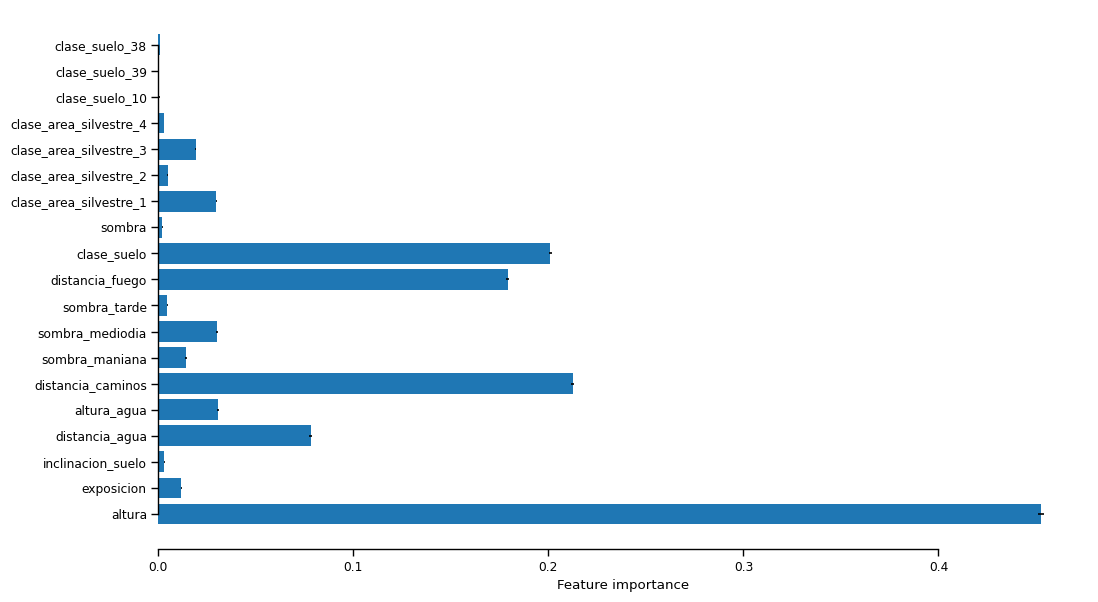

In [27]:
from sklearn.inspection import permutation_importance
r = permutation_importance(best_model, prep_test, test_target, n_repeats=20, random_state=1234)

fig, ax = plt.subplots(figsize=(12, 7))
sns.set_context('paper')

ax.barh(features, r.importances_mean, xerr=r.importances_std)
ax.set_xlabel('Feature importance')
sns.despine(trim=True)

The features taken from the categories of `clase_suelo` didn't do a great job. Maybe because of the correlation with `clase_suelo` being still in the data, let's try removing `clase_suelo`. The feature `sombra` also did not perform well, there is no point in keeping all three original `sombra_*` 

## Feature Engineering (again)

In [28]:
target = data['dosel_forestal']
prep_data2 = data.drop(['dosel_forestal', 'clase_suelo', 'sombra_maniana', 'sombra_tarde', 'sombra_mediodia'], axis=1)

In [29]:
rf_classifier2 = RandomForestClassifier(n_estimators=50, random_state=1234, n_jobs=-1)
rf_classifier2.fit(prep_data2, target)
rf_prediction2 = rf_classifier2.predict(prep_data2)

In [30]:
acc = accuracy_score(target.to_numpy(), rf_prediction2)
prec = precision_score(target.to_numpy(), rf_prediction2, average='macro')
rec = recall_score(target.to_numpy(), rf_prediction2, average='macro')

print(f'Accuracy:\t{acc:.8f}\nPrecision:\t{prec:.8f}\nRecall:\t\t{rec:.8f}')

Accuracy:	0.99998386
Precision:	0.99998356
Recall:		0.99979165


In [36]:
# Import testing set
test_set = pd.read_pickle(os.path.join(DATA_SUBDIR, 'test.pkl'))

# Combine shades
test_set['sombra'] = test_set[['sombra_maniana', 'sombra_mediodia', 'sombra_tarde']].mean(axis=1)

# One-hot encoding
clase_area_silvestre_one_hot_encoded = pd.get_dummies(test_set['clase_area_silvestre'], prefix='clase_area_silvestre')
clase_suelo_one_hot_encoded = pd.get_dummies(test_set['clase_suelo'], prefix='clase_suelo')

# I'll encode this entirely so I'll drop the original
test_set.drop('clase_area_silvestre', axis=1, inplace=True)

test_set = pd.concat([test_set, clase_area_silvestre_one_hot_encoded, clase_suelo_one_hot_encoded[['clase_suelo_10', 'clase_suelo_39', 'clase_suelo_38']]], axis=1)

prep_test2 = test_set.drop(['dosel_forestal', 'clase_suelo', 'sombra_maniana', 'sombra_tarde', 'sombra_mediodia'], axis=1)

rf_test_prediction2 = rf_classifier2.predict(prep_test2)

acc = accuracy_score(test_target.to_numpy(), rf_test_prediction2)
prec = precision_score(test_target.to_numpy(), rf_test_prediction2, average='macro')
rec = recall_score(test_target.to_numpy(), rf_test_prediction2, average='macro')

print(f'Accuracy:\t{acc:.8f}\nPrecision:\t{prec:.8f}\nRecall:\t\t{rec:.8f}')

Accuracy:	0.94791420
Precision:	0.94002399
Recall:		0.89178508


Not good, I assume because of the information dropped with `clase_suelo`. Let's not drop it this time but drop the features I made from it.

In [39]:
target = data['dosel_forestal']
prep_data2 = data.drop(['dosel_forestal', 'sombra_maniana', 'sombra_tarde', 'sombra_mediodia', 'clase_suelo_10', 'clase_suelo_38', 'clase_suelo_39',], axis=1)

In [40]:
rf_classifier2 = RandomForestClassifier(n_estimators=50, random_state=1234, n_jobs=-1)
rf_classifier2.fit(prep_data2, target)
rf_prediction2 = rf_classifier2.predict(prep_data2)

In [41]:
acc = accuracy_score(target.to_numpy(), rf_prediction2)
prec = precision_score(target.to_numpy(), rf_prediction2, average='macro')
rec = recall_score(target.to_numpy(), rf_prediction2, average='macro')

print(f'Accuracy:\t{acc:.8f}\nPrecision:\t{prec:.8f}\nRecall:\t\t{rec:.8f}')

Accuracy:	0.99997042
Precision:	0.99998428
Recall:		0.99985180


In [42]:
# Import testing set
test_set = pd.read_pickle(os.path.join(DATA_SUBDIR, 'test.pkl'))

# Combine shades
test_set['sombra'] = test_set[['sombra_maniana', 'sombra_mediodia', 'sombra_tarde']].mean(axis=1)

# One-hot encoding
clase_area_silvestre_one_hot_encoded = pd.get_dummies(test_set['clase_area_silvestre'], prefix='clase_area_silvestre')
# clase_suelo_one_hot_encoded = pd.get_dummies(test_set['clase_suelo'], prefix='clase_suelo')

# I'll encode this entirely so I'll drop the original
test_set.drop('clase_area_silvestre', axis=1, inplace=True)

test_set = pd.concat([test_set, clase_area_silvestre_one_hot_encoded], axis=1)

prep_test2 = test_set.drop(['dosel_forestal', 'sombra_maniana', 'sombra_tarde', 'sombra_mediodia'], axis=1)

rf_test_prediction2 = rf_classifier2.predict(prep_test2)

acc = accuracy_score(test_target.to_numpy(), rf_test_prediction2)
prec = precision_score(test_target.to_numpy(), rf_test_prediction2, average='macro')
rec = recall_score(test_target.to_numpy(), rf_test_prediction2, average='macro')

print(f'Accuracy:\t{acc:.8f}\nPrecision:\t{prec:.8f}\nRecall:\t\t{rec:.8f}')

Accuracy:	0.96038166
Precision:	0.95123861
Recall:		0.91465418


Maybe a fine tunned version would give a better result

In [44]:
from sklearn.model_selection import GridSearchCV

param_grid = [
	{'bootstrap': [True, False], 'n_estimators': [50, 70, 100], 'max_features': [5, 7, 13]},
]

rf_gscv_classifier = RandomForestClassifier(random_state=1234)

grid_search = GridSearchCV(rf_gscv_classifier, param_grid, cv=5, n_jobs=2, return_train_score=True)
grid_search.fit(prep_data2, target)

This previous block didn't finish executing before deadline. So I stick with the best so far. In order to test it use the script `test_model.py`